Copyright (c) 2017,2018, Johannes Schöneberg. All rights reserved.
The default copyright laws apply.

In [1]:
import csv


#http://soft-matter.github.io/trackpy/v0.3.2/tutorial/walkthrough.html


from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
#mpl.rc('figure',  figsize=(10, 6))
#mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims

import scipy


import math



import scipy.ndimage

#own modules / functions
import sys
pythonPackagePath = "/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis/"
sys.path.append(pythonPackagePath+"/modules")
import InputProcessing as inproc
import ForceFileProcessing as ffp
import TubeProcessing as tubeProc


#### plot definitions
#https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
#c_ch1 = 'aqua'
#c_ch1 = 'deepskyblue'
#c_ch1 = 'cyan'

#c_ch2 = 'springgreen'
#c_ch2 = 'lime'
#c_ch3 = 'red'
#lwidth = 3

#xlimit = (-150,300)

In [2]:
# read input parameters:
path = '/Users/johannesschoeneberg/Desktop/PostDoc/hurley_lab/pulling_confleezers_dataSharing_local/2018-06-05_movie1/'

inputParameters = pd.read_csv(path+'_info.csv',names=['key','value'])
inputParameters

,key,value
0,input_data_folder,./
1,output_data_folder,./analysisOutput/
2,vesicleID_of_that_day,7
3,forceFile_raw_originalFilename,measurement__149.lvm
4,forceFile_raw_dataShareFilename,forceFile_raw.lvm
5,forceFile,forceFile.csv
6,forceFile_plot,forceFile.png
7,forceFile_alpha_y,-1519
8,forceFile_kappa_y,0.1992
9,forceFile_startTime,2018-06-05 13:38:11


In [3]:
# read the tube vector from a previous step

inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")
tubeVectorFileName = inproc.getInputParameter(inputParameters,"tube_vector_file")


df_tubeVector = pd.read_csv(path+inputDataFolder+tubeVectorFileName)
df_tubeVector.columns=['frame','tubeLenght',"vesicle_attachment_x",'vesicle_attachment_y','bead_attachment_x','bead_attachment_y']
df_tubeVector[0:5]


,frame,tubeLenght,vesicle_attachment_x,vesicle_attachment_y,bead_attachment_x,bead_attachment_y
0,0,75.026662,120.0,71.0,45.0,69.0
1,1,75.026662,120.0,71.0,45.0,69.0
2,2,73.027392,120.0,71.0,47.0,69.0
3,3,75.026662,120.0,71.0,45.0,69.0
4,4,75.026662,120.0,71.0,45.0,69.0


# calculate tube intensity for channel 0

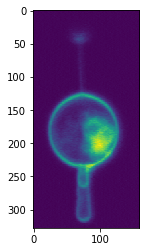

In [4]:
inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")
movie_zoomVesicle_ch0 = inproc.getInputParameter(inputParameters,"movie_zoomVesicle_ch0")

frames_ch0 = pims.TiffStack_pil(path+inputDataFolder+movie_zoomVesicle_ch0) 
plt.imshow(frames_ch0[0])

[ 93.  71.]


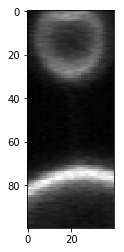

In [5]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch0

frameId = 500
image = frames[frameId]
marginx = 50
marginy = 20
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)
midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()

# fit tube to a gaussian for on frame in the movie

[ 93.  71.]
33.3766385366
13 13


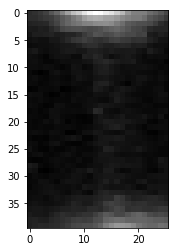

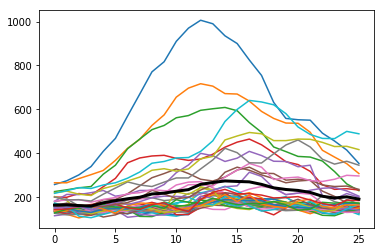

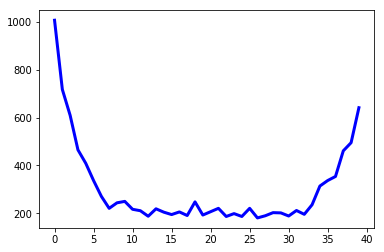

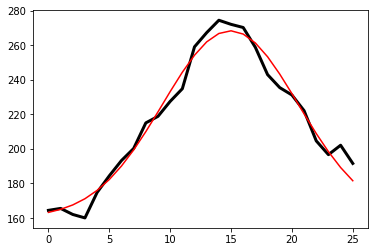

mean: 14.9502178041 stdev: 5.57567627521 max: 268.297766464 FWHM: 13.1307176281 offset: 160.254217585 maxx: 268.297766464
fit parameters: mean: 14.950217804086247 variance: -5.575676275208728 amplitude: -1510.032608148671 yshift: 160.2542175851172


In [6]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points



frames = frames_ch0

frameId = 500
image = frames[frameId]
marginx = 20
marginy = -1 # will be calculated from tube length

#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)

tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
print(tubeLength)
marginy = int(0.8*tubeLength/2)
print(marginy,marginy)

midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()


#----------------
# look at the individual lines

for line in image_centeredOnVesicleAttachmentVector:
    plt.plot(line)

plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
plt.show()

maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
plt.plot(maximaForEveryLine,color='b',lw=3)    
plt.show()


#----------------
# average the individual lines

averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
# guess that the center sits on the max                               
guess_mean = np.argmax(averagedIntensity)
# guess that the variance is where the halfmax is
halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
# get the indexes of the elements to the right of the maximum that are larger than the halfmax
indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
# the length of that list is our sigma guess
guess_sigma = len(indexes)

# our guess for the y-shift is the minimum of the averaged traces
guess_yShift = np.min(averagedIntensity)

# out guess for the amplitude is the difference between min and max of the trace
guess_amplitude = halfmax*2


                               
                               
                               
#----------------  
# do the fit:
                               
p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
#print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=True);


amplitude = fit[5] #maxx-offset




# fit tube to a gaussian for all frames in the movie

In [7]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch0

outputDataFolder = inproc.getInputParameter(inputParameters,"output_data_folder")

verbose = False
fits = []

counter = 0
#for frameId in range(0,10):
for frameId in range(0,len(frames)):
    
    if(counter%10==0):
        print(counter)
    try:
        image = frames[frameId]
        marginx = 20
        marginy = -1 # will be calculated from tube length
        
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                          df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
        beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                          df_tubeVector['bead_attachment_y'].iloc[frameId]]
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
        #print(tubeMidpoint)
        
        tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
        #print(tubeLength)
        marginy = int(0.8*tubeLength/2)
        #print(marginy,marginy)
        
        midx = int(tubeMidpoint[0])
        midy = int(tubeMidpoint[1])
        image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]
    
        if(verbose):
            plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')
            plt.show()
            
            
        try:    
            maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
            filename_maxEveryLine = path+outputDataFolder+movie_zoomVesicle_ch0+'__flIntMaxAlongTube_'+str(counter)+'.csv'
            df = pd.DataFrame(maximaForEveryLine)
            df.to_csv(filename_maxEveryLine, header=['fluorescenceMaximaForEveryLineAlongTubeVector'])
        except ValueError:
            print('something went wrong. skip')
            
        if(verbose):
            plt.plot(maximaForEveryLine,color='b',lw=3)    
            plt.show()
        
        
        if(verbose):
            for line in image_centeredOnVesicleAttachmentVector:
                plt.plot(line)
            plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
            plt.show()
        
        averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
        # guess that the center sits on the max                               
        guess_mean = np.argmax(averagedIntensity)
        # guess that the variance is where the halfmax is
        halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
        # get the indexes of the elements to the right of the maximum that are larger than the halfmax
        indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
        # the length of that list is our sigma guess
        guess_sigma = len(indexes)
        
        # our guess for the y-shift is the minimum of the averaged traces
        guess_yShift = np.min(averagedIntensity)
        
        # out guess for the amplitude is the difference between min and max of the trace
        guess_amplitude = halfmax*2
        
        
                                       
                                       
                                       
                
        
                                       
        p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
        if(False):
            print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
       
        fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=False);
    except (TypeError, ZeroDivisionError,IndexError) as e:
        fit = np.array([])
    fits.append(fit)
    counter = counter +1
    
    

fits = np.array(fits)

fits = np.array(fits)
filenamePath_gaussFit_ch0 = path+outputDataFolder+movie_zoomVesicle_ch0+'__gaussFitAlongTube.csv'
df = pd.DataFrame(fits.tolist())
df.to_csv(filenamePath_gaussFit_ch0,header=['mean','stdev','fit[0][2]','offset','maxx','maxx-offset','FWHM','fitconvergence','background_median','maxx-background_median'])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
something went wrong. skip


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid 

something went wrong. skip
something went wrong. skip
something went wrong. skip
1490
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1500
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1510
1520
1530
1540
something went wrong. skip
1550
1560
1570
1580


/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in multiply
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))


1590
1600
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1610
1620
1630
1640
1650
1660
something went wrong. skip
1670
something went wrong. skip
1680
something went wrong. skip
1690
1700
something went wrong. skip
something went wrong. skip
something went wrong. skip
1710
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1720


[ -67.     -66.667  -66.334 ...,  505.76   506.093  506.426]


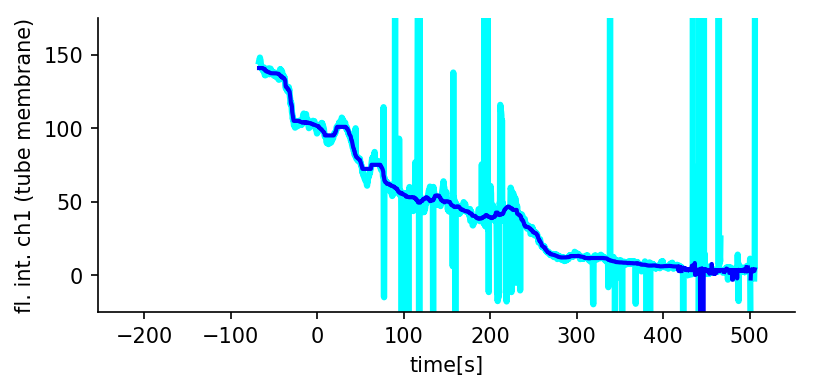

In [34]:
plt.figure(dpi=150)
plt.gca().set_aspect(1.7)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


deltaT = int(inproc.getInputParameter(inputParameters,"movie_startTime_difference_UVstart_seconds"))
frameRate = float(inproc.getInputParameter(inputParameters,"time_between_frames_seconds"))
time = deltaT + np.arange(0,len(frames))*frameRate
print(time)

df_fit_ch0 = pd.read_csv(filenamePath_gaussFit_ch0)
plt.plot(time,df_fit_ch0['maxx-background_median'],color='cyan',lw=3)
plt.plot(time,scipy.ndimage.median_filter(df_fit_ch0['maxx-background_median'],60),lw=2,c='blue');
plt.xlabel('time[s]')
plt.ylabel('fl. int. ch1 (tube membrane)')
plt.ylim(-25,175)
plt.xlim(-253.5,552.5)



filenamePath_gaussFit_ch0_pretty = path+outputDataFolder+movie_zoomVesicle_ch0+'__gaussFitAlongTube_medianFilter60.csv'
y = scipy.ndimage.median_filter(df_fit_ch0['maxx-background_median'],60)
d = {'time[s]': time.tolist(), 'fluorescenceIntensityTube[AU]': y.tolist()}
df = pd.DataFrame(data=d)
df.to_csv(filenamePath_gaussFit_ch0_pretty)

# channel 1

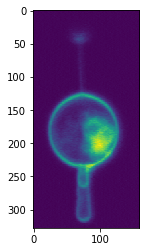

In [9]:
inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")
movie_zoomVesicle_ch1 = inproc.getInputParameter(inputParameters,"movie_zoomVesicle_ch1")

frames_ch1 = pims.TiffStack_pil(path+inputDataFolder+movie_zoomVesicle_ch1) 
plt.imshow(frames[0])

[ 82.  70.]


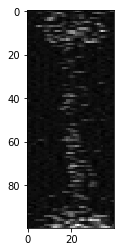

In [10]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch1

frameId = 0
image = frames[frameId]
marginx = 50 #display margin in x around tube midpoint
marginy = 20 #display margin in y around tube midpoint
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)
midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()

[ 82.  70.]
75.0266619276
30 30


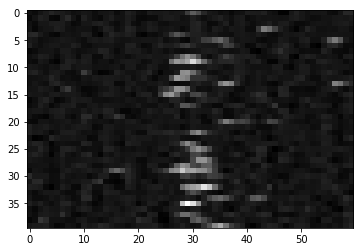

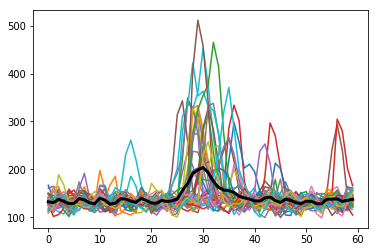

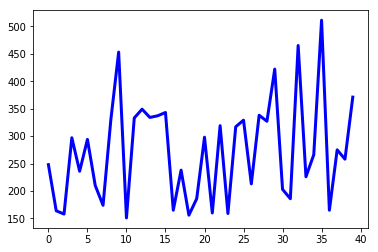

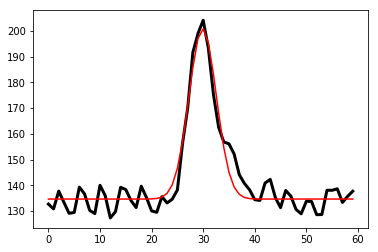

mean: 29.9028467062 stdev: 2.64851277304 max: 200.873955746 FWHM: 6.2372475805 offset: 134.639223476 maxx: 200.873955746
fit parameters: mean: 29.90284670621531 variance: 2.6485127730368196 amplitude: 439.7215914521512 yshift: 134.63922347558537


In [11]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points



frames = frames_ch1

frameId = 0
image = frames[frameId]
marginx = 20
marginy = -1 # will be calculated from tube length

#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)

tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
print(tubeLength)
marginy = int(0.8*tubeLength/2)
print(marginy,marginy)

midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()


#----------------
# look at the individual lines

for line in image_centeredOnVesicleAttachmentVector:
    plt.plot(line)

plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
plt.show()

maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
plt.plot(maximaForEveryLine,color='b',lw=3)    
plt.show()


#----------------
# average the individual lines

averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
# guess that the center sits on the max                               
guess_mean = np.argmax(averagedIntensity)
# guess that the variance is where the halfmax is
halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
# get the indexes of the elements to the right of the maximum that are larger than the halfmax
indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
# the length of that list is our sigma guess
guess_sigma = len(indexes)

# our guess for the y-shift is the minimum of the averaged traces
guess_yShift = np.min(averagedIntensity)

# out guess for the amplitude is the difference between min and max of the trace
guess_amplitude = halfmax*2


                               
                               
                               
#----------------  
# do the fit:
                               
p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
#print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=True);


amplitude = fit[5] #maxx-offset





In [12]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch1

outputDataFolder = inproc.getInputParameter(inputParameters,"output_data_folder")

verbose = False
fits = []

counter = 0
#for frameId in range(0,10):
for frameId in range(0,len(frames)):
    
    if(counter%10==0):
        print(counter)
    try:
        image = frames[frameId]
        marginx = 20
        marginy = -1 # will be calculated from tube length
        
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                          df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
        beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                          df_tubeVector['bead_attachment_y'].iloc[frameId]]
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
        #print(tubeMidpoint)
        
        tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
        #print(tubeLength)
        marginy = int(0.8*tubeLength/2)
        #print(marginy,marginy)
        
        midx = int(tubeMidpoint[0])
        midy = int(tubeMidpoint[1])
        image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]
    
        if(verbose):
            plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')
            plt.show()
            
            
        try:    
            maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
            filename_maxEveryLine = path+outputDataFolder+movie_zoomVesicle_ch1+'__flIntMaxAlongTube_'+str(counter)+'.csv'
            df = pd.DataFrame(maximaForEveryLine)
            df.to_csv(filename_maxEveryLine, header=['fluorescenceMaximaForEveryLineAlongTubeVector'])
        except ValueError:
            print('something went wrong. skip')
        
        if(verbose):
            plt.plot(maximaForEveryLine,color='b',lw=3)    
            plt.show()
        
        
        if(verbose):
            for line in image_centeredOnVesicleAttachmentVector:
                plt.plot(line)
            plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
            plt.show()
        
        averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
        # guess that the center sits on the max                               
        guess_mean = np.argmax(averagedIntensity)
        # guess that the variance is where the halfmax is
        halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
        # get the indexes of the elements to the right of the maximum that are larger than the halfmax
        indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
        # the length of that list is our sigma guess
        guess_sigma = len(indexes)
        
        # our guess for the y-shift is the minimum of the averaged traces
        guess_yShift = np.min(averagedIntensity)
        
        # out guess for the amplitude is the difference between min and max of the trace
        guess_amplitude = halfmax*2
        
        
                                       
                                       
                                       
                
        
                                       
        p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
        if(False):
            print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
       
        fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=verbose);
    except (TypeError, ZeroDivisionError,IndexError) as e:
        fit = np.array([])
    fits.append(fit)
    counter = counter +1
    
    

fits = np.array(fits)
filenamePath_gaussFit_ch1 = path+outputDataFolder+movie_zoomVesicle_ch1+'__gaussFitAlongTube.csv'
df = pd.DataFrame(fits.tolist())
df.to_csv(filenamePath_gaussFit_ch1,header=['mean','stdev','fit[0][2]','offset','maxx','maxx-offset','FWHM','fitconvergence','background_median','maxx-background_median'])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in true_divide
 

1490
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1500
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1510
1520
1530
1540
something went wrong. skip
1550
1560
1570
1580
1590


/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in multiply
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))


1600
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1610
1620
1630
1640
1650
1660
something went wrong. skip
1670
something went wrong. skip
1680
something went wrong. skip
1690
1700
something went wrong. skip
something went wrong. skip
something went wrong. skip
1710
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1720


[ -67.     -66.667  -66.334 ...,  505.76   506.093  506.426]


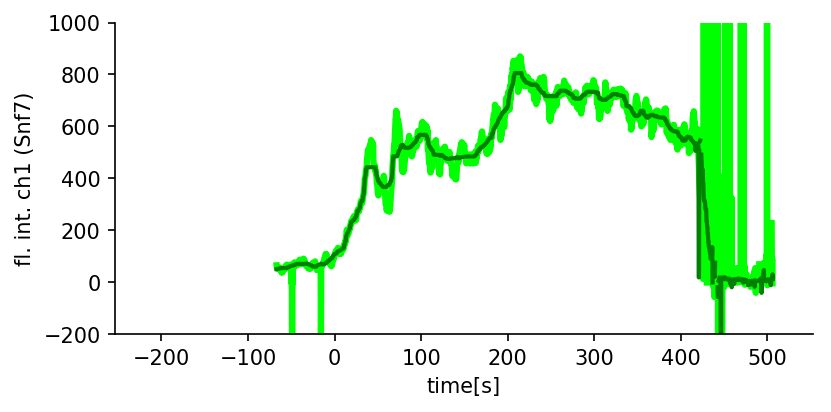

In [36]:
plt.figure(dpi=150)
plt.gca().set_aspect(0.3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

deltaT = int(inproc.getInputParameter(inputParameters,"movie_startTime_difference_UVstart_seconds"))
frameRate = float(inproc.getInputParameter(inputParameters,"time_between_frames_seconds"))
time = deltaT + np.arange(0,len(frames))*frameRate
print(time)

df_fit_ch1 = pd.read_csv(filenamePath_gaussFit_ch1)
plt.plot(time,df_fit_ch1['maxx-background_median'],color='lime',lw=3)
plt.plot(time,scipy.ndimage.median_filter(df_fit_ch1['maxx-background_median'],60),lw=2,c='green');
plt.xlabel('time[s]')
plt.ylabel('fl. int. ch1 (Snf7)')
plt.ylim(-200,1000)
plt.xlim(-253.5,552.5)


filenamePath_gaussFit_ch1_pretty = path+outputDataFolder+movie_zoomVesicle_ch1+'__gaussFitAlongTube_medianFilter60.csv'
y = scipy.ndimage.median_filter(df_fit_ch1['maxx-background_median'],60)
d = {'time[s]': time.tolist(), 'fluorescenceIntensityTube[AU]': y.tolist()}
df = pd.DataFrame(data=d)
df.to_csv(filenamePath_gaussFit_ch1_pretty)

# ch2 analysis 

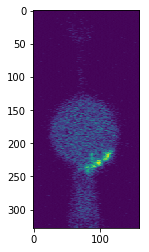

In [14]:
inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")
movie_zoomVesicle_ch2 = inproc.getInputParameter(inputParameters,"movie_zoomVesicle_ch2")

frames_ch2 = pims.TiffStack_pil(path+inputDataFolder+movie_zoomVesicle_ch2) 
plt.imshow(frames[0])

[ 82.  70.]


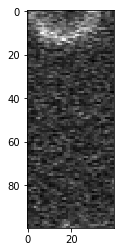

In [15]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch2

frameId = 0
image = frames[frameId]
marginx = 50 #display margin in x around tube midpoint
marginy = 20 #display margin in y around tube midpoint
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)
midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()

[ 82.  70.]
75.0266619276
30 30


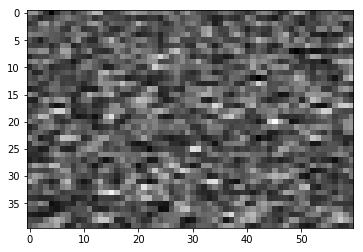

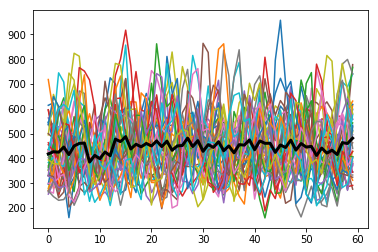

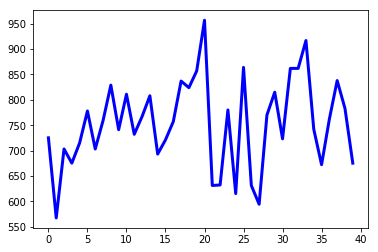

/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


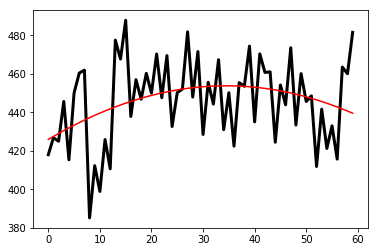

mean: 34.4762611168 stdev: 117.13077248 max: 453.775746203 FWHM: 275.842969191 offset: -203.492566199 maxx: 453.775746203
fit parameters: mean: 34.4762611167775 variance: -117.13077248031631 amplitude: -192976.14953470693 yshift: -203.4925661986809
amplitude above background: 5.0[AU]


In [16]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points



frames = frames_ch2

frameId = 3
image = frames[frameId]
marginx = 20
marginy = -1 # will be calculated from tube length

#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)

tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
print(tubeLength)
marginy = int(0.8*tubeLength/2)
print(marginy,marginy)

midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()


#----------------
# look at the individual lines

for line in image_centeredOnVesicleAttachmentVector:
    plt.plot(line)

plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
plt.show()

maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
plt.plot(maximaForEveryLine,color='b',lw=3)    
plt.show()


#----------------
# average the individual lines

averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
# guess that the center sits on the max                               
guess_mean = np.argmax(averagedIntensity)
# guess that the variance is where the halfmax is
halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
# get the indexes of the elements to the right of the maximum that are larger than the halfmax
indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
# the length of that list is our sigma guess
guess_sigma = len(indexes)

# our guess for the y-shift is the minimum of the averaged traces
guess_yShift = np.min(averagedIntensity)

# out guess for the amplitude is the difference between min and max of the trace
guess_amplitude = halfmax*2


                               
                               
                               
#----------------  
# do the fit:
                               
p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
#print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=True);


amplitude = fit[7] #maxx-background
print("amplitude above background: {}[AU]".format(amplitude))






In [17]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch2

outputDataFolder = inproc.getInputParameter(inputParameters,"output_data_folder")

verbose = False
fits = []

counter = 0
#for frameId in range(0,10):
for frameId in range(0,len(frames)):
    
    if(counter%10==0):
        print(counter)
    try:
        image = frames[frameId]
        marginx = 20
        marginy = -1 # will be calculated from tube length
        
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                          df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
        beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                          df_tubeVector['bead_attachment_y'].iloc[frameId]]
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
        #print(tubeMidpoint)
        
        tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
        #print(tubeLength)
        marginy = int(0.8*tubeLength/2)
        #print(marginy,marginy)
        
        midx = int(tubeMidpoint[0])
        midy = int(tubeMidpoint[1])
        image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]
    
        if(verbose):
            plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')
            plt.show()
            
        try:    
            maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
            filename_maxEveryLine = path+outputDataFolder+movie_zoomVesicle_ch2+'__flIntMaxAlongTube_'+str(counter)+'.csv'
            df = pd.DataFrame(maximaForEveryLine)
            df.to_csv(filename_maxEveryLine, header=['fluorescenceMaximaForEveryLineAlongTubeVector'])
        except ValueError:
            print('something went wrong. skip')
        
        if(verbose):
            plt.plot(maximaForEveryLine,color='b',lw=3)    
            plt.show()
        
        
        if(verbose):
            for line in image_centeredOnVesicleAttachmentVector:
                plt.plot(line)
            plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
            plt.show()
        
        averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
        # guess that the center sits on the max                               
        guess_mean = np.argmax(averagedIntensity)
        # guess that the variance is where the halfmax is
        halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
        # get the indexes of the elements to the right of the maximum that are larger than the halfmax
        indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
        # the length of that list is our sigma guess
        guess_sigma = len(indexes)
        
        # our guess for the y-shift is the minimum of the averaged traces
        guess_yShift = np.min(averagedIntensity)
        
        # out guess for the amplitude is the difference between min and max of the trace
        guess_amplitude = halfmax*2
        
        
                                       
                                       
                                       
                
        
                                       
        p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
        if(False):
            print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
       
        fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=verbose);
    except (TypeError, ZeroDivisionError,IndexError) as e:
        fit = np.array([])
    fits.append(fit)
    counter = counter +1
    
    

fits = np.array(fits)
filenamePath_gaussFit_ch2 = path+outputDataFolder+movie_zoomVesicle_ch2+'__gaussFitAlongTube.csv'
df = pd.DataFrame(fits.tolist())
df.to_csv(filenamePath_gaussFit_ch2,header=['mean','stdev','fit[0][2]','offset','maxx','maxx-offset','FWHM','fitconvergence','background_median','maxx-background_median'])

/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in multiply
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2))

170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
something went wrong. skip


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


something went wrong. skip
something went wrong. skip
something went wrong. skip
1490
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1500
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1510
1520
1530
1540
something went wrong. skip
1550
1560
1570
1580
1590
1600
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1610
1620
1630
1640
1650
1660
something went wrong. skip
1670
something went wrong. skip
1680
something went wrong. skip
1690
1700
something went wrong. skip
something went wrong. skip
something went wrong. skip
1710
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1720


[ -67.     -66.667  -66.334 ...,  505.76   506.093  506.426]


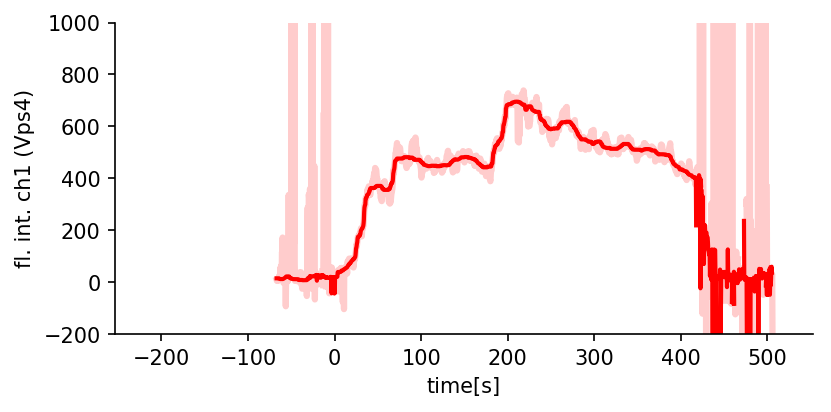

In [37]:
plt.figure(dpi=150)
plt.gca().set_aspect(0.3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

deltaT = int(inproc.getInputParameter(inputParameters,"movie_startTime_difference_UVstart_seconds"))
frameRate = float(inproc.getInputParameter(inputParameters,"time_between_frames_seconds"))
time = deltaT + np.arange(0,len(frames))*frameRate
print(time)

df_fit_ch2 = pd.read_csv(filenamePath_gaussFit_ch2)
plt.plot(time,df_fit_ch2['maxx-background_median'],color='red',alpha=0.2,lw=3)
plt.plot(time,scipy.ndimage.median_filter(df_fit_ch2['maxx-background_median'],60),lw=2,c='red');
plt.xlabel('time[s]')
plt.ylabel('fl. int. ch1 (Vps4)')
plt.ylim(-200,1000)
plt.xlim(-253.5,552.5)

filenamePath_gaussFit_ch2_pretty = path+outputDataFolder+movie_zoomVesicle_ch2+'__gaussFitAlongTube_medianFilter60.csv'
y = scipy.ndimage.median_filter(df_fit_ch2['maxx-background_median'],60)
d = {'time[s]': time.tolist(), 'fluorescenceIntensityTube[AU]': y.tolist()}
df = pd.DataFrame(data=d)
df.to_csv(filenamePath_gaussFit_ch2_pretty)